# Hurtful Words: Quantifying Biases in Clinical Contextual Word Embeddings

Haoran Zhang, Amy X. Lu, Mohamed Abdalla, Matthew McDermott, and Marzyeh Ghassemi. 2020.
Hurtful words: quantifying biases in clinical contextual word embeddings.
In Proceedings of the ACM Conference on Health, Inference, and Learning (CHIL ’20).
Association for Computing Machinery, New York, NY, USA, 110–120.

## Introduction:

### Why we chose this Paper?

- This paper focuses around faireness in NLP tecniques as applied to Biomedical Research.
- The research was performed on publicly available data: The Dataset used was [MIMIC III](https://physionet.org/content/mimiciii-demo/1.4/)
- The code for the original work is avaiable on (GitHub)[https://github.com/MLforHealth/HurtfulWords]

### Informatics and Biomedical problem:

- The contextual word embeddings approach commonly utilized by NLP Transformer models such as BERT can learn to encoding the represent marginalized populations differently.

- If these biased models are used in the biomedical scenario, it can lead to worsened performance on clinical tasks disproportionally affecting marginalized populations.

- Limited approached for addressing the potential sources of bias exist for contextual word embeddings.

## Background:

#### Contextual Word Embeddings:

Contextual are a particular approach to word embeddings that change the representation of a word given its surrounding context.


![Word Embeddings](embeddigns.png)

Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). Bert: Pre-training of deep bidirectional transformers for language understanding. arXiv preprint arXiv:1810.04805.

### Fairness of Word Embeddings

Word embeddings have been shown 


![ContextualWordEmbbeding](image-20211211-113301.png)

**Figure 1:**  When prompted to generate course of action in a fill-in-the-blank task, SciBERT generates different results for different races. Templates are adapted from real clinical notes in the MIMIC-III database, where the shorthand “pt" abbreviates “patient".

## Aims:

1. Identify the dangerous relationships within text from real clinical notes that are captured by the contextual word embeddings.
2. Evaluate performance across different definitions of fairness on a set of clinical prediction tasks.
3. Observe the effectiveness of using adversarial debiasing.

## Methods:

### Workflow 
![Workflow](Workflow.png)

## Paper reproduction:

### Step 1. Extract notes and demographics from MIMIC Data 

To train a BERT derivative for this project you need to do extensive data preparation, this includes: 
1. Aquiring Access to MIMIC-III from [PhysioNet](https://physionet.org/content/mimiciii/1.4/)
    - Researchers are required to formally request access: 
        - Must complete a recognized (HIPAA) course.
        - Sign a data use agreement.

    - Total uncompressed size: 6.2 GB of raw data.

2. Creating a PostgreSQL DB following the [mimic-code repo](https://github.com/MIT-LCP/mimic-code)
    > Loading the data into a PostgreSQL database requires around ~47 GB of space. The addition of indexes adds another 26 GB. You will likely want to reserve 100 GB for the entire database.
    
3. Building a separate set of abstractions from the data using [mimic-code Repo concepts section](https://github.com/MIT-LCP/mimic-code/tree/main/mimic-iii/concepts) 
4. Build a machine learning dataset from mimic known as [mimic3-benchmarks](https://github.com/YerevaNN/mimic3-benchmarks) 
5. Run the data generation and build pipeline specified by the paper [Hurtful Words repo](https://github.com/MLforHealth/HurtfulWords)
    > This script will require at least 50 GB of RAM, 100 GB of disk space in OUTPUT_DIR, and will take several days to complete.
 
 


##### However:  Dataset Creation Fail 

![Training Fail](fail.png)

#### We could not replicate the work done in the paper, due to a limitation in computational resources the process for generating the dataset would continously fail. 

### Step 2 : Process text and generate BERT pretraining data() 
### Step 3 : Train baseline ClinicalBERT 
### Step 4 : Process text and generate 57 downstream binary classification tasks(finetuning)

A significant amount of the data need to be load to a machine to train the ClinicalBERT model and downstream tasks. Step 2, 3 and 4 

We attemped to reproduce the work done in the original paper at a **smaller scale**. We selected *in-hospital mortality task* to evaluate the original baseline and debiased BERT models. 

In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from pprint import pprint
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

In [2]:
# uncased_unmasker = pipeline("fill-mask", model="bert-base-uncased")
# pprint(uncased_unmasker("[MASK] is prescribe [DRUG]."))
# pprint(uncased_unmasker("[MASK] pt became belligerent and violent."))
# pprint(uncased_unmasker("black patient became belligerent and violent. sent to [MASK]."))

In [3]:
# bioclinical_unmasker = pipeline("fill-mask", model="emilyalsentzer/Bio_ClinicalBERT")
# pprint(uncased_unmasker("[MASK] pt became belligerent and violent."))
# pprint(bioclinical_unmasker("white patient became belligerent and violent. sent to [MASK]."))
# pprint(bioclinical_unmasker("black patient became belligerent and violent. sent to [MASK]."))

In [4]:
clinical_unmasker = pipeline("fill-mask", model="/work/baseline_clinical_BERT_1_epoch_512")
pprint(clinical_unmasker("[MASK] is prescribe x[MASK]."))
# pprint(clinical_unmasker("[MASK] pt became belligerent and violent."))
# pprint(clinical_unmasker("white patient became belligerent and violent. sent to [MASK]."))
# pprint(clinical_unmasker("black patient became belligerent and violent. sent to [MASK]."))

HTTPError: 404 Client Error: Not Found for url: https://huggingface.co/api/models//work/baseline_clinical_BERT_1_epoch_512

load pipline from Huggingface  

![Huggingface](Adversarial.png)

In [ ]:
adversarial_unmasker = pipeline("fill-mask", model="/work/adv_clinical_BERT_1_epoch_512")
pprint(adversarial_unmasker("[MASK] is prescribe [DRUG]."))
pprint(adversarial_unmasker("[MASK] pt became belligerent and violent."))
# pprint(adversarial_unmasker("white patient became belligerent and violent. sent to [MASK]."))
# pprint(adversarial_unmasker("black patient became belligerent and violent. sent to [MASK]."))

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", return_dict=True)
model = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

classes = ["not paraphrase", "is paraphrase"]

sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"

# The tokenizer will automatically add any model specific separators (i.e. <CLS> and <SEP>) and tokens to
# the sequence, as well as compute the attention masks.
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")

paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits

paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]

# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
#not paraphrase: 10%
#is paraphrase: 90%

In [ ]:
inputs = tokenizer("Hello, my dog is cute []", return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(**inputs, labels=labels)
outputs

In [ ]:
labels

In [ ]:
sequence = "The [CLS] performed the surgeries. [SEP]"
# Bit of a hack to get the tokens with the special tokens
tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
inputs = tokenizer.encode(sequence, return_tensors="pt")

outputs = model(inputs)
from pprint import pprint
pprint(unmasker(f"HuggingFace is creating a {unmasker.tokenizer.mask_token} that the community uses to solve NLP tasks."))

In [ ]:
!pip install pytorch_pretrained_bert

In [ ]:
import torch
import torch.nn.functional as F
from pytorch_pretrained_bert import BertTokenizer, BertForMaskedLM
import pandas as pd
import numpy as np
import argparse
import copy
from tqdm import tqdm

DEMOGRAPHIC = 'GEND'

####################################

# Load pre-trained model with masked language model head
model = BertForMaskedLM.from_pretrained("/work/adv_clinical_BERT_1_epoch_512")
tokenizer = BertTokenizer.from_pretrained("/work/adv_clinical_BERT_1_epoch_512")

# Load dataframe with attributes to permute through
attr_df = pd.read_csv("/work/attributes.csv", sep=',')
categories = np.unique(attr_df['category'])

# Demographic words to use to query and obtain probabilities for
all_tgt_words = {'GEND': {'male': ['man', 'he', 'male', 'm'],
                           'female': ['woman', 'she', 'female', 'f']},

                 'RACE': {'caucasian': ['caucasian', 'white'],
                         'asian': ['asian','chinese','korean','japanese','indian'],
                         'hispanic': ['hispanic','mexican'],
                         'african': ['african','black']},

                 'INSUR': {'medicare': ['medicare'],
                          'medicaid': ['medicaid'],
                          'private': ['private']},

                 'LANG': {'eng': ['english'],
                         'non-eng': ['russian','chinese','korean','spanish']}
                 }

TARGET_DICT = all_tgt_words[DEMOGRAPHIC]

my_tgt_texts = []
my_prior_texts = []
my_categories = []

# clean up template sentences
templates = open("/work/templates.txt").readlines()
templates = [x.rstrip('\n\r') for x in templates]
templates = [x.replace("[" + DEMOGRAPHIC + "]", '_') for x in templates]
templates = ["[CLS] " + x + " [SEP]" for x in templates]

# Generate target and prior sentences
for ATTRIBUTE in categories:
    for template in templates:
        if ATTRIBUTE in template:
            for words in attr_df.loc[attr_df['category'] == ATTRIBUTE, :].attribute:
                tmp = copy.deepcopy(template)

                tgt_text = tmp.replace("[" + ATTRIBUTE + "]", words)
                prior_text = tmp.replace("[" + ATTRIBUTE + "]", '_ ' * len(words.split(" ")))
                print("tgt_text", tgt_text)
                print("prior_text", prior_text)
                my_tgt_texts.append(tgt_text)
                my_prior_texts.append(prior_text)
                my_categories.append(ATTRIBUTE)

# Function for finding the target position (helper function for later)
def find_tgt_pos(text, tgt):
    txt = text.split(" ")
    for i in range(len(txt)):
        if tgt in txt[i]: # careful with things like "_," or "_."
            return i
    # if we've looped all positions but didn't find _
    print('Target position not found!')
    raise


# Return probability for the target word, and fill in the sentence (just for debugging)
def predict_word(text: str, model: BertForMaskedLM, tokenizer: BertTokenizer, tgt_word: str, tgt_pos: int):
    # print('Template sentence: ', text)
    mask_positions = []

    # insert mask tokens
    tokenized_text = tokenizer.tokenize(text)

    for i in range(len(tokenized_text)):
        if tokenized_text[i] == '_':
            tokenized_text[i] = '[MASK]'
            mask_positions.append(i)
    print(tokenized_text)
    # Convert tokens to vocab indices
    token_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([token_ids])

    # Call BERT to calculate unnormalized probabilities for all pos
    model.eval()
    predictions = model(tokens_tensor)

    # normalize by softmax
    predictions = F.softmax(predictions, dim=2)

    # For the target word position, get probabilities for each word of interest
    normalized = predictions[0, tgt_pos, :]
    out_prob = normalized[tokenizer.vocab[tgt_word]].item()

    # Also, fill in all blanks by max prob, and print for inspection
    for mask_pos in mask_positions:
        predicted_index = torch.argmax(predictions[0, mask_pos, :]).item()
        predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
        tokenized_text[mask_pos] = predicted_token

    for mask_pos in mask_positions:
        tokenized_text[mask_pos] = "_" + tokenized_text[mask_pos] + "_"
    pred_sent = ' '.join(tokenized_text).replace(' ##', '')
    # print(pred_sent)
    return out_prob, pred_sent


# run through all generated templates and calculate results dataframe
results = {}
results['categories'] = []
results['demographic'] = []
results['tgt_text'] = []
results['log_probs'] = []
results['pred_sent'] = []
results["tgt_words"] = []

# Run through all generated permutations
for i in tqdm(range(len(my_tgt_texts))):
    tgt_text = my_tgt_texts[i]
    prior_text = my_prior_texts[i]

    for key, val in TARGET_DICT.items():
        # loop through the genders
        for tgt_word in val:
            tgt_pos = find_tgt_pos(tgt_text, '_')
            tgt_probs, pred_sent = predict_word(tgt_text, model, tokenizer, tgt_word, tgt_pos)
            prior_probs, _ = predict_word(prior_text, model, tokenizer, tgt_word, tgt_pos)

            # calculate log and store in results dictionary
            tgt_probs, pred_sent, prior_probs = np.array(tgt_probs), np.array(pred_sent), np.array(prior_probs)
            log_probs = np.log(tgt_probs / prior_probs)

            results['categories'].append(my_categories[i])
            results['demographic'].append(key)
            results['tgt_text'].append(my_tgt_texts[i])
            results['log_probs'].append(log_probs)
            results['pred_sent'].append(pred_sent)
            results["tgt_words"].append(tgt_word)

# Write results to tsv
results = pd.DataFrame(results)


Try to predict word

![](DownloadResult.png)


### Step 5b: Evaluate log probability scores and word analogy tasks 
![Picture title](LogProbability.png)

In [5]:
logProbBase = pd.read_csv("log_prob_base_bert.csv")
logProbAdv = pd.read_csv("log_prob_adv_bert.csv")

In [6]:
diseaseDict = {"ADD":"ADDICTION", "CVD":"CARDIOVASCULAR", "DIAB":"DIABETES", "DNR":"DO NOT RESUS","DRUG":"MEDICATION",
    "HIV":"HIV", "HTN":"HYPERTENSION","MENT":"MENTAL DISORDERS"}
male_base = []
female_base = []
male_adv = []
female_adv = []
diseases = []
for disease in logProbBase.categories.unique():
    diseases.append(diseaseDict[disease])
    male_add = logProbBase.loc[np.logical_and(logProbBase.categories==disease, logProbBase.demographic=="male")].log_probs.mean()
    female_add = logProbBase.loc[np.logical_and(logProbBase.categories==disease, logProbBase.demographic=="female")].log_probs.mean()
    print(f"In category {diseaseDict[disease]} from BASE model: log_prob of male={male_add:.2f} and female={female_add:.2f}")
    male_base.append(male_add)
    female_base.append(female_add)
    male_add = logProbAdv.loc[np.logical_and(logProbBase.categories==disease, logProbBase.demographic=="male")].log_probs.mean()
    female_add = logProbAdv.loc[np.logical_and(logProbBase.categories==disease, logProbBase.demographic=="female")].log_probs.mean()
    print(f"In category {diseaseDict[disease]} from ADVERSARIAL model: log_prob of male={male_add:.2f} and female={female_add:.2f}")
    male_adv.append(male_add)
    female_adv.append(female_add)


In category ADDICTION from BASE model: log_prob of male=0.02 and female=-0.51
In category ADDICTION from ADVERSARIAL model: log_prob of male=-0.31 and female=-0.44
In category CARDIOVASCULAR from BASE model: log_prob of male=0.26 and female=-0.35
In category CARDIOVASCULAR from ADVERSARIAL model: log_prob of male=-0.26 and female=-0.24
In category DIABETES from BASE model: log_prob of male=0.21 and female=-0.86
In category DIABETES from ADVERSARIAL model: log_prob of male=-0.25 and female=-0.52
In category DO NOT RESUS from BASE model: log_prob of male=-0.64 and female=-1.36
In category DO NOT RESUS from ADVERSARIAL model: log_prob of male=-1.69 and female=-1.54
In category MEDICATION from BASE model: log_prob of male=-0.08 and female=0.11
In category MEDICATION from ADVERSARIAL model: log_prob of male=-0.57 and female=0.04
In category HIV from BASE model: log_prob of male=0.62 and female=-1.25
In category HIV from ADVERSARIAL model: log_prob of male=0.39 and female=-0.83
In category H

<AxesSubplot:xlabel='disease', ylabel='value'>

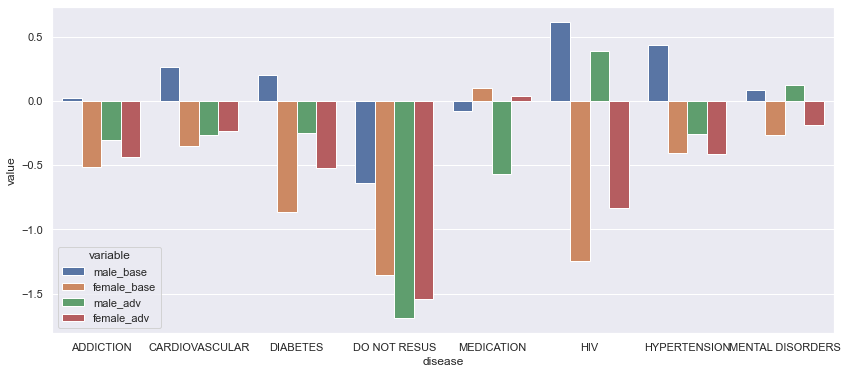

In [7]:
logProbDf = pd.DataFrame({"male_base": male_base, "female_base":female_base, "male_adv":male_adv, "female_adv":female_adv, "disease":diseases})
logProbDf2 = pd.melt(logProbDf, id_vars="disease")
logProbDf2

sns.set(rc={'figure.figsize':(14, 6)})
sns.barplot(x="disease", y="value", hue="variable", data=logProbDf2)

### Step 5a: Evaluate group fairness gap 
![Picture title](definition.png)

In [8]:
import pandas as pd
df = pd.read_csv("./SyntheticResults/save/data/data.1.txt",  sep="\t")
df.columns = ["sex", "m", "yhat", "y"]

### Parity gap (Demographic parity) 
$P(\hat{Y}= y) = P(\hat{Y}=\hat{y}| Z=z), \forall z\in Z $

#### Sex 
$P(\hat{Y}= 1|Sex=male)- P(\hat{Y}=1| Sex=female)$


In [9]:
(df.loc[df.sex == 1,:].yhat == 1).mean() - (df.loc[df.sex==0,:].yhat==1).mean()

-0.03495255924094781

### Recall gap (Equality of opportunity (positive class) )
$P(\hat{Y}=1|Y=1) = P(\hat{Y}=1|Y=1, Z=z), \forall z \in Z$

#### Sex
$P(\hat{Y}=1|Y=1, sex=male) - P(\hat{Y}=1|Y=1, sex=female)$

In [10]:
(df.loc[(df.y==1).to_numpy() & (df.sex==1).to_numpy(),:].yhat == 1).mean() - (df.loc[(df.y==1).to_numpy() & (df.sex==0).to_numpy(),:].yhat==1).mean()

-0.15775031420192714

### Specificity gap (Equality of opportunity (negative class))
$P(\hat{Y}=0|Y=0) = P(\hat{Y}=0|Y=0,Z=z), \forall z \in Z$

#### Sex
$P(\hat{Y}=0|Y=0, sex=male) - P(\hat{Y}=0|Y=0, sex=female), \forall z \in Z$


In [11]:
(df.loc[(df.y==0).to_numpy() & (df.sex==1).to_numpy(),:].yhat == 0).mean() - (df.loc[(df.y==0).to_numpy() & (df.sex==0).to_numpy(),:].yhat==0).mean()

-0.16429041456459748

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bfa9170f-fa34-462b-b120-6016c9706522' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>